[실습 진행 예제 코드](https://github.com/st-tech/zr-obp/tree/master/examples/online)

SyntheticBanditDataset을 온라인 밴딧 알고리즘의 OPE를 검증에 사용한다.     
잘 알려진 off-policy 정책 추정기의 추정 성능을 검증하는데 synthetic data로 계산 가능한 검증 정책의 그라운드 트루스 정책 값을 사용한다.

Replay Method(RM)의 추정 성능을 검증한다. 
## RM
로깅 밴딧 피드백 데이터의 서브셋을 사용하는데      
이 로깅 데이터에서 선택된 액션들이 evaluation_policy와 같은 behavior_policy를 사용해서 선택된다.     
evaluation_policy가 고정되고 behavior_policy가 유니폼 랜덤이면 unbiased 하다고 한다.    
보통 evaluation_policy가 학습 알고리즘이면 잘 동작한다고 한다.   

In [1]:
from sklearn.linear_model import LogisticRegression
from obp.ope import (
    OffPolicyEvaluation,
    ReplayMethod,
    InverseProbabilityWeighting as IPW,
    DirectMethod,
    RegressionModel
)
from obp.policy import LinUCB
from obp.dataset import SyntheticBanditDataset
from obp.dataset import logistic_reward_function
from obp.simulator import (
    run_bandit_simulation,
    calc_ground_truth_policy_value
)


In [2]:
# ope_estimators = [ReplayMethod(), IPW(), DirectMethod()]
ope_estimators = [ReplayMethod(), IPW()]

In [3]:
n_runs = 1
n_rounds = 10000
n_actions = 10
dim_context = 5
n_sim = 1
evaluation_policy_name = 'lin_ucb'
n_jobs = 1
random_seed = 12345


In [4]:
evaluation_policy = LinUCB(dim=dim_context, n_actions=n_actions, random_state=random_seed)

uniformly random state 를 사용하는 synthetic dataset generator.    
오프라인 정책 검증을 위한 데이터셋을 생성한다.

In [5]:
dataset = SyntheticBanditDataset(
    n_actions = n_actions,
    dim_context = dim_context, 
    reward_type='binary',
    reward_function = logistic_reward_function, # 랜덤하게 생성한 파라미터들로 sigmoid(logit) # reward_type도 있긴하다.
    reward_std = 1.0,
    behavior_policy_function = None, # Uniformly random 
    tau = 1.0,
    random_state = random_seed, 
    dataset_name='synthetic_bandit_dataset'
)

1. behavior_policy 를 사용해서 action을 샘플링한다. 
2. context를 이용해서 expected_reward를 reward_function을 사용해서 계산한다
3. scipy.truncnorm(잘린 정규 분포 : 확률 분포에 범위를 제한) 을 사용해서 expected_reward를 수정한다.
4. expected_reward를 사용해서 reward를 계산한다. 

behavior_policy에 None을 넣으면 Uniformly Random Sampling으로 action을 선택한다. 

In [6]:
import numpy as np 
import random 

context = np.random.normal(size=(n_rounds, dim_context))
print(context.shape)
behavior_policy = np.ones(n_actions) / n_actions 
print(behavior_policy.shape)
print(behavior_policy)
behavior_policy = np.tile(behavior_policy, (n_rounds, 1))
print(behavior_policy.shape)

(10000, 5)
(10,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
(10000, 10)


새로운 synthetic logged bandit feedback의 샘플링한다

In [7]:
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

In [8]:
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'context', 'action_context', 'action', 'position', 'reward', 'expected_reward', 'pscore'])

뭐지 ? expected_reward와 reward의 차이가 무엇인가? 
```
expected_reward_ = self.calc_expected_reward(context)
return self.sample_reward_given_expected_reward(expected_reward_, action)
```
Reward Type이 binomial 인지 continous 인지에 따라 random sampling 하는게 달라진다. 


In [9]:
# ML 모델로 평균 보상 함수를 추정한다. 
regression_model = RegressionModel(
    n_actions = dataset.n_actions,
    len_list = dataset.len_list, 
    action_context = dataset.action_context, 
    base_model = LogisticRegression(max_iter=10000, C=100, random_state=12345)
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context = bandit_feedback['context'],
    action = bandit_feedback['action'], 
    reward = bandit_feedback['reward'], 
    position = bandit_feedback['position'], 
    pscore = bandit_feedback['pscore'], 
    n_folds = 3, 
    random_state = random_seed
)

estimated_rewards_by_reg_model.shape

(10000, 10, 1)

검증 정책(LinUCB)을 시뮬레이트 한다

In [10]:
action_dist = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=evaluation_policy)

100%|██████████| 10000/10000 [00:00<00:00, 12022.68it/s]


검증 정책의 그라운드 트루스 정책 값을 추정한다    
보상 분포는 p(r|x,a)를 사용한 몬테 카를로 결과를 사용한다

주어진 온라인 밴딧 알고리즘의 그라운드 트루스 정책 값을 몬테 카를로 시뮬레이션을 사용해서 계산한다 
n_sim 만큼 전체 과정을 반복한다. 
- 정책을 초기화 한다. ( deepcopy )
- bandit_feedback에 기록되어 있는 각 round 마다 
    - 검증 정책을 사용해 각 라운드의 액션을 선택한다. 
    - 검증 정책이 선택한 액션과 bandit_feedback['expected_reward']로 누적 보상을 계산한다. 
    - 검증 정책이 선택한 액션과 reward_sampler의 결과로 나온 reward를 사용해서 검증 정책을 업데이트한다. 
- 누적 보상 / ( n_sim * bandit_feedback['n_rounds'] ) 를 리턴한다. 

In [11]:
ground_truth_policy_value = calc_ground_truth_policy_value(
    bandit_feedback = bandit_feedback,
    reward_sampler = dataset.sample_reward, # p(r|x,a)
    policy = evaluation_policy, 
    n_sim = n_sim # 시뮬레이션 진행 횟수 
)

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


In [12]:
ground_truth_policy_value

0.7066556496362245

relative estimation error(relative-ee)를 사용해서 추정기의 성능을 검증한다

# OffPolicyEvaluation 
추정기 들로 OPE를 수행하기 위한 클래스 

## 파라미터 
- bandit_feedback : OPE를 수행에 사용하는 밴딧 피드백 로그
- ope_estimators : 검증 정책의 정책 값을 검증하는데 사용되는 OPE 추정기( obp.ope.BaseOffPolicyEstimator 인터페이스를 따라야함 ) 리스트

## 함수 
1. _create_estimator_inputs( action_dist, estimated_rewards_by_reg_model )
2. estimate_policy_value( action_dist, estimated_rewards_by_reg_model )
3. estimated_intervals( action_dist, estimated_rewards_by_reg_model, alpha, n_bootstrap_samples, random_state ) 
4. summarize_off_policy_estimates( action_dist, estimated_rewards_by_reg_model, alpha, n_bootstrap_samples, random_state )
5. visualize_off_policy_estimates ( action_dist, estimated_rewards_by_reg_model, alpha, is_relative, n_bootstrap_samples, random_state, fig_dir, fig_name )
6. evaluate_performance_of_estimators( ground_truth_policy_value, action_dist, estimated_rewards_by_reg_model, metric )
7. summarize_estimators_comparision( ground_truth_policy_value, action_dist, estimated_rewards_by_reg_model, metric )
8. visualize_off_policy_estimates_of_multiple_polices(policy_name_list, action_dist_list, estimated_rewards_by_reg_model, alpha, is_relative, n_bootstrap_samples, random_state, fig_dir, fig_name )

* DM 이나 DR 추정기 같은 모델에 의존하는 추정기가 아니면, estimated_rewards_by_reg_model은 사용하지는 않는다. 


In [13]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback, 
    ope_estimators = ope_estimators, 
)

## _create_estimator_inputs( action_dist, estimted_rewards_by_reg_model )
ope_estimators에 정의한 추정기 마다 입력으로 사용할 action_dist 와 estimated_rewards_by_reg_model을 나눈다.

In [14]:
estimator_input = ope._create_estimator_inputs(action_dist=action_dist)
estimator_input

{'rm': {'reward': array([1, 1, 1, ..., 0, 1, 0]),
  'action': array([6, 4, 2, ..., 9, 4, 7]),
  'position': array([0, 0, 0, ..., 0, 0, 0]),
  'pscore': array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]),
  'action_dist': array([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [1.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [1.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [1.]],
  
         ...,
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [1.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [1.],
          [0.]]]),
  'estimated_rewards_by_reg_model': None},
 'ipw': {'reward': array([1, 1, 1, ..., 

## estimated_policy_values ( action_dist, estimated_rewards_by_reg_model )
검증 정책의 정책 값을 추정한다. 추정기 들마다 구현한 estimate_policy_value 함수를 수행한 결과를 리턴한다.


In [15]:
estimated_policy_value = ope.estimate_policy_values(action_dist=action_dist)
estimated_policy_value

{'rm': 0.6407480314960629, 'ipw': 0.651}

## estimated_intervals( action_dist, estimated_rewards_by_reg_model, alpha, n_bootstrap_samples, random_state )
정책 값의 신뢰 구간을 파라미터가 없는 부츠스트랩으로 추정한다. 추정기 들마다 구현한 estimated_interval 함수를 수행한 결과를 리턴한다.

In [16]:
estimated_interval = ope.estimate_intervals(action_dist=action_dist)
estimated_interval


{'rm': {'mean': 0.6431003937007873,
  '95.0% CI (lower)': 0.5939222440944882,
  '95.0% CI (upper)': 0.6924458661417323},
 'ipw': {'mean': 0.65035,
  '95.0% CI (lower)': 0.599475,
  '95.0% CI (upper)': 0.693525}}

In [17]:
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(action_dist=action_dist)
print(estimated_policy_value) # relative_estimated_policy_value는 behavior policy의 정책 값을 나눈 값이다. 
print(estimated_interval)

     estimated_policy_value  relative_estimated_policy_value
rm                 0.640748                         1.062248
ipw                0.651000                         1.079244
        mean  95.0% CI (lower)  95.0% CI (upper)
rm   0.64310          0.589518          0.712328
ipw  0.64436          0.593425          0.692200


## visualize_off_policy_estimates( action_dist, estimated_rewards_by_reg_model, alpha, is_relative, n_bootstrap_samples, random_state, fig_dir, fig_name )
1. estimated_round_rewards 를 각 추정기 마다 구현된 _estimate_round_rewards를 사용해서 계산한다
2. seaborn.barplot 을 사용해서 round_rewards를 그린다

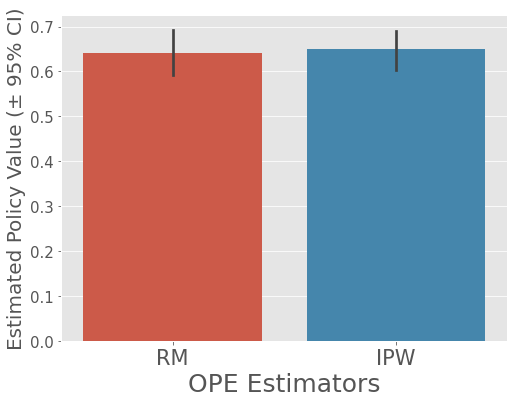

In [18]:
visualize_policy_estimates = ope.visualize_off_policy_estimates(action_dist=action_dist)

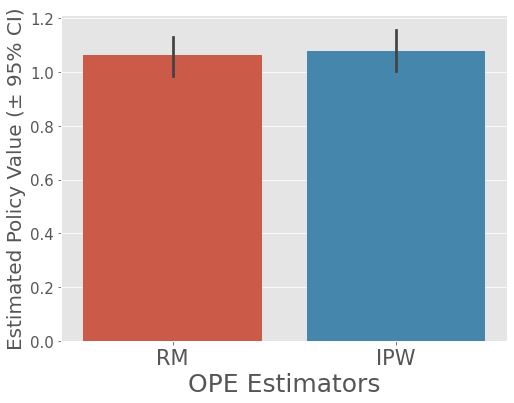

In [19]:
visualize_policy_estimates = ope.visualize_off_policy_estimates(action_dist=action_dist, is_relative=True)

## evaluate_performance_of_estimators( ground_truth_policy_value, action_dist, estimated_rewards_by_reg_model, metric)
OPE 추정기 들의 추정 성능을 검증한다. 추정기의 estimate_policy_value 함수로 정책 값을 추정한다
- Relative Estimation Error[ relative_ee ] := abs( (estimated - ground_truth) / ground_truth )
- Squared Error [ se ] := ( estimated - ground_truth ) ** 2

In [20]:
relative_ee_i = ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=ground_truth_policy_value, 
    action_dist=action_dist, 
)
se_i = ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=ground_truth_policy_value,
    action_dist=action_dist, 
    metric='se'
)

In [21]:
print(f'{relative_ee_i}')


print(f'{se_i}')

{'rm': 0.0932669514127424, 'ipw': 0.07875922263534603}
{'rm': 0.004343814128909366, 'ipw': 0.0030975513364301754}


## summarize_estimators_comparision( ground_truth_policy_value, action_dist, estimated_rewards_by_reg_model, metric )
OPE 추정기들의 성능 비교를 요약한다

In [22]:
relative_ee_j = ope.summarize_estimators_comparison(ground_truth_policy_value=ground_truth_policy_value,
                                                    action_dist=action_dist)

relative_ee_j

,relative-ee
rm,0.093267
ipw,0.078759


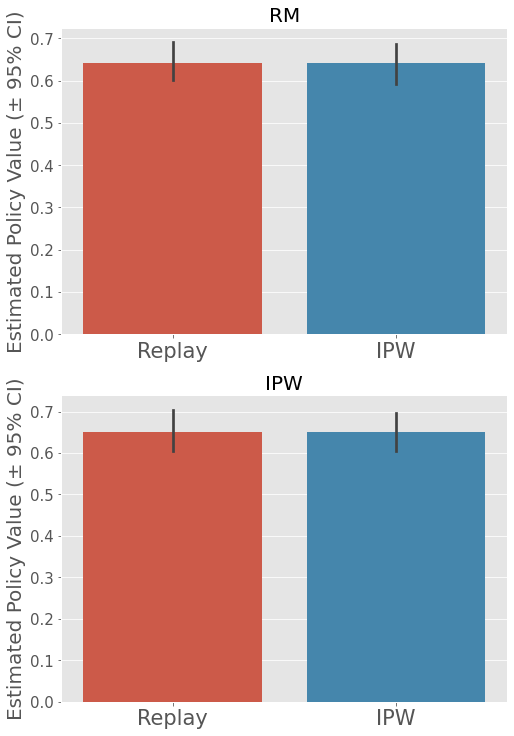

In [23]:
ope.visualize_off_policy_estimates_of_multiple_policies(policy_name_list=['Replay', 'IPW'],
                                                    action_dist_list=[action_dist, action_dist])